<a href="https://colab.research.google.com/github/R12942159/NTU_ML/blob/Hw3/Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
import csv
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from PIL import Image
from tqdm.auto import tqdm
from torch.optim import Adam
from torchvision import transforms as tr
from torch.utils.data import DataLoader, Dataset, random_split

In [ ]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c ml2023-fall-hw3
!unzip 'ml2023-fall-hw3.zip'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using: {device}")

Using: cuda


#### Build Dataset and Dataloader

##### read the img first

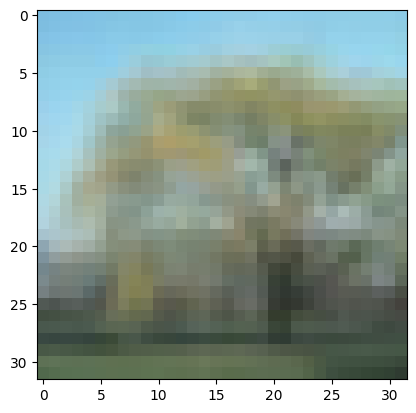

In [ ]:
img = np.load('/content/data/trainX.npy')[999] / 255.

plt.imshow(img)
plt.show()

##### Build dataset

In [ ]:
class Hw3_dataset(torch.utils.data.Dataset):
    def __init__(self, data_path: str, to_tensor, transform, augmentation=True) -> None:
        self.all_data = np.load(data_path)
        self.to_tensor = to_tensor
        self.transform = transform
        self.augmentation = augmentation

        hflip = tr.RandomHorizontalFlip(p=0.5) # Horizontal flip 50%
        vflip = tr.RandomVerticalFlip(p=0.5) # Vertical flip 50%
        rotate = tr.RandomRotation(degrees=15) # Rotation 15 degrees
        color = tr.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1) # Color jitter

        # keeping the original picture in 25%
        def origine(x): return x
        if augmentation:
            self.augmentation = [hflip, vflip, rotate, origine]
        else:
            self.augmentation = [origine]

    def __len__(self):
        return len(self.all_data)

    def __getitem__(self, idx):
        # read img
        img = self.all_data[idx] # (3, 32, 32)

        # to tensor type
        img = self.to_tensor(img)
        img /= 255.

        # transform/normalize img
        img_aug = self.transform(img)

        # augmentation img
        augment = random.choice(self.augmentation)
        img_aug = augment(img_aug)
        return img_aug, img

In [ ]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

img_ds = Hw3_dataset(
    '/content/data/trainX.npy',
    to_tensor = tr.Compose([
        tr.ToTensor(),
    ]),
    transform = tr.Compose([
        tr.Normalize(mean=mean, std=std),
    ]),
    augmentation = True,
)

##### Randomly divided into a training and validation dataset.

In [ ]:
train_prob = 0.85

train_size = int(len(img_ds) * train_prob)
val_size = int(len(img_ds) - train_size)
train_ds, val_ds = random_split(img_ds, [train_size, val_size])

##### Build Dataloders

In [ ]:
BATCH_SIZE = 128
IMG_SIZE = 32

train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(img_ds, BATCH_SIZE, shuffle=False)

#### Contruct Network and convalution block

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding='same'):
        super(ConvBlock, self).__init__()
        self.convblock = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),

            nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def __call__(self, x):
        return self.convblock(x)

class Net(nn.Module):
    def __init__(self, in_channels=3, init_channels=16, latent_dim=128, img_size=IMG_SIZE):
        super(Net, self).__init__()
        self.init_channels = init_channels
        self.img_size = img_size

        # Encoder
        self.encoder = nn.Sequential(
            ConvBlock(in_channels, init_channels), # (3, H, W) -> (16, H, W)
            nn.MaxPool2d(2),

            ConvBlock(init_channels, init_channels*2), # (16, H/2, W/2) -> (32, H/2, W/2)
            nn.MaxPool2d(2),

            ConvBlock(init_channels*2, init_channels*4), # (32, H/4, W/4) -> (64, H/4, W/4)
        )

        # bottleneck
        self.fc1 = nn.Linear(init_channels*4 * (img_size//4) ** 2, latent_dim) # 64 * H/4 * W/4 -> 128
        self.fc2 = nn.Linear(latent_dim, init_channels*4 * (img_size//4) ** 2) # 128 -> 64 * H/4 * W/4

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(init_channels*4, init_channels*2, kernel_size=2, stride=2), # (64, H/4, W/4) -> (32, H/2, W/2)
            ConvBlock(init_channels*2, init_channels*2),
            nn.ConvTranspose2d(init_channels*2, init_channels, kernel_size=2, stride=2), # (32, H/2, W/2) -> (16, H, W)
        )

        # Output
        self.output = nn.Conv2d(init_channels, in_channels, kernel_size=1) # (16, H, W) -> (3, H, W)

    def __call__(self, x):
        # Encoder
        x = self.encoder(x)

        # Bottleneck
        bottleneck = self.fc1(x.reshape(x.shape[0], -1))
        x = self.fc2(bottleneck).reshape(-1, self.init_channels*4, self.img_size//4, self.img_size//4)

        # Decoder
        x = self.decoder(x)
        x = self.output(x)
        return bottleneck, x

In [ ]:
import torchsummary

model = Net().to(device)
torchsummary.summary(model, (3, 32, 32), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,320
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
         MaxPool2d-7           [-1, 16, 16, 16]               0
            Conv2d-8           [-1, 32, 16, 16]           4,640
       BatchNorm2d-9           [-1, 32, 16, 16]              64
             ReLU-10           [-1, 32, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           9,248
      BatchNorm2d-12           [-1, 32, 16, 16]              64
             ReLU-13           [-1, 32, 16, 16]               0
        MaxPool2d-14             [-1, 3

#### Define training and validate process

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.train() # to training mode.
    epoch_loss = 0
    for batch_i, (img_aug, img) in enumerate(tqdm(dataloader, leave=False)):
        img_aug, img = img_aug.to(device, dtype=torch.float), img.to(device,  dtype=torch.float) # move data to GPU

        _, reconsturction = model(img_aug)
        loss = loss_fn(reconsturction, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # write to logs
        epoch_loss += loss.item() # tensor -> python value

    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches


def validate(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss = 0

    # No gradient for test data
    with torch.no_grad():
        for batch_i, (img_aug, img) in enumerate(dataloader):
            img_aug, img = img_aug.to(device,  dtype=torch.float), img.to(device,  dtype=torch.float)

            _, reconsturction = model(img_aug)
            loss = loss_fn(reconsturction, img)

            # write to logs
            epoch_loss += loss.item()

    return epoch_loss/num_batches

In [ ]:
EPOCHS = 100

model = Net().to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

logs = {
    'train_loss': [], 'val_loss': []
}

# early stopping
patience = 10
counter = 0
best_loss = np.inf

for epoch in tqdm(range(EPOCHS)):
    train_loss = train(train_loader, model, loss_fn, optimizer)
    val_loss = validate(val_loader, model, loss_fn)

    print(f'EPOCH: {(epoch+1):04d} -> train_loss: {train_loss:.4f} \ val_loss: {val_loss:.4f}')

    logs['train_loss'].append(train_loss)
    logs['val_loss'].append(val_loss)

    # if epoch % 10 == 0:
    #     torch.save(model.state_dict(), f'DL_hw2_epoch{epoch+1}_model.pth')
    # chcek improvement
    if val_loss <  best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        torch.save(model.state_dict(), '/content/drive/MyDrive/NTU_ML/Hw3/ckpt/best_model.pth')
        print('-------------------- Model Save --------------------')
    else:
        counter += 1
    if counter >= patience:
        print('-------------------- Early Stop --------------------')
        break

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0001 -> train_loss: 1.5264 \ val_loss: 1.5083
-------------------- Model Save --------------------


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0002 -> train_loss: 1.5184 \ val_loss: 1.5047
-------------------- Model Save --------------------


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0003 -> train_loss: 1.5169 \ val_loss: 1.5044
-------------------- Model Save --------------------


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0004 -> train_loss: 1.5157 \ val_loss: 1.5032
-------------------- Model Save --------------------


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0005 -> train_loss: 1.5153 \ val_loss: 1.5026
-------------------- Model Save --------------------


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0006 -> train_loss: 1.5150 \ val_loss: 1.5029


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0007 -> train_loss: 1.5149 \ val_loss: 1.5027


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0008 -> train_loss: 1.5146 \ val_loss: 1.5024
-------------------- Model Save --------------------


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0009 -> train_loss: 1.5141 \ val_loss: 1.5020
-------------------- Model Save --------------------


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0010 -> train_loss: 1.5144 \ val_loss: 1.5020


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0011 -> train_loss: 1.5141 \ val_loss: 1.5019
-------------------- Model Save --------------------


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0012 -> train_loss: 1.5143 \ val_loss: 1.5019
-------------------- Model Save --------------------


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0013 -> train_loss: 1.5142 \ val_loss: 1.5020


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0014 -> train_loss: 1.5136 \ val_loss: 1.5019


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0015 -> train_loss: 1.5140 \ val_loss: 1.5014
-------------------- Model Save --------------------


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0016 -> train_loss: 1.5140 \ val_loss: 1.5017


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0017 -> train_loss: 1.5137 \ val_loss: 1.5019


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0018 -> train_loss: 1.5139 \ val_loss: 1.5018


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0019 -> train_loss: 1.5134 \ val_loss: 1.5016


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0020 -> train_loss: 1.5138 \ val_loss: 1.5015


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0021 -> train_loss: 1.5133 \ val_loss: 1.5016


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0022 -> train_loss: 1.5135 \ val_loss: 1.5014
-------------------- Model Save --------------------


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0023 -> train_loss: 1.5135 \ val_loss: 1.5017


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0024 -> train_loss: 1.5136 \ val_loss: 1.5016


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0025 -> train_loss: 1.5133 \ val_loss: 1.5022


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0026 -> train_loss: 1.5135 \ val_loss: 1.5012
-------------------- Model Save --------------------


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0027 -> train_loss: 1.5133 \ val_loss: 1.5013


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0028 -> train_loss: 1.5134 \ val_loss: 1.5013


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0029 -> train_loss: 1.5133 \ val_loss: 1.5013


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0030 -> train_loss: 1.5132 \ val_loss: 1.5012


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0031 -> train_loss: 1.5130 \ val_loss: 1.5015


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0032 -> train_loss: 1.5130 \ val_loss: 1.5013


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0033 -> train_loss: 1.5132 \ val_loss: 1.5012
-------------------- Model Save --------------------


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0034 -> train_loss: 1.5133 \ val_loss: 1.5013


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0035 -> train_loss: 1.5131 \ val_loss: 1.5014


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0036 -> train_loss: 1.5131 \ val_loss: 1.5011
-------------------- Model Save --------------------


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0037 -> train_loss: 1.5129 \ val_loss: 1.5010
-------------------- Model Save --------------------


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0038 -> train_loss: 1.5131 \ val_loss: 1.5011


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0039 -> train_loss: 1.5132 \ val_loss: 1.5011


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0040 -> train_loss: 1.5131 \ val_loss: 1.5011


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0041 -> train_loss: 1.5130 \ val_loss: 1.5014


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0042 -> train_loss: 1.5129 \ val_loss: 1.5011


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0043 -> train_loss: 1.5126 \ val_loss: 1.5009
-------------------- Model Save --------------------


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0044 -> train_loss: 1.5128 \ val_loss: 1.5012


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0045 -> train_loss: 1.5128 \ val_loss: 1.5010


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0046 -> train_loss: 1.5128 \ val_loss: 1.5009


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0047 -> train_loss: 1.5129 \ val_loss: 1.5011


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0048 -> train_loss: 1.5127 \ val_loss: 1.5013


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0049 -> train_loss: 1.5133 \ val_loss: 1.5011


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0050 -> train_loss: 1.5130 \ val_loss: 1.5013


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0051 -> train_loss: 1.5130 \ val_loss: 1.5012


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0052 -> train_loss: 1.5127 \ val_loss: 1.5014


  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0053 -> train_loss: 1.5126 \ val_loss: 1.5011
-------------------- Early Stop --------------------


#### Define Clustering Process

In [ ]:
def clustering(model, device, loader, n_iter, reduced_method, reduced_dim, perplexity):
    assert reduced_method in ['pca', 'tsne', None]

    model.eval()
    latent_vec = torch.tensor([]).to(device, dtype=torch.float)
    for idx, (image_aug, image) in enumerate(loader):
        print("predict %d / %d" % (idx, len(loader)) , end='\r')
        image = image.to(device, dtype=torch.float)
        latent, r = model(image)
        latent_vec = torch.cat((latent_vec, latent), dim=0)

    latent_vec = latent_vec.cpu().detach().numpy()

    if reduced_method == 'tsne':
        tsne = TSNE(n_components=reduced_dim, verbose=1, method='exact', perplexity=perplexity, n_iter=n_iter)
        latent_vec = tsne.fit_transform(latent_vec)
    elif reduced_method == 'pca':
        pca = PCA(n_components=reduced_dim, copy=False, whiten=True, svd_solver='full')
        latent_vec = pca.fit_transform(latent_vec)

    kmeans = KMeans(n_clusters=2, random_state=0, max_iter=n_iter).fit(latent_vec)
    return kmeans.labels_

#### Inference

In [ ]:
def write_output(predict_result, file_name='predict.csv'):
    with open(file_name, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['id', 'label'])
        for i in range(len(predict_result)):
            writer.writerow([str(i), str(predict_result[i])])

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/NTU_ML/Hw3/ckpt/43best_model.pth'))
predicted = clustering(model, device, test_loader, 1000, reduced_method='tsne', reduced_dim=2, perplexity=15)
write_output(predicted, 'pred.csv')